This blog post will demonstrate how to use a Fourier Transform (FT) in Python to analyze data in the frequency-domain. An FT is designed to convert a time-domain signal into the frequency-domain. The Fast Fourier Transform (FFT), developed by Tukey et al. in the 1960s, is the most commonly used algorithm to accomplish a Fourier Transform in practice. 

Features which may be hidden or invisible in the time-domain may be easier to assess in the frequency-domain. Converting time-domain data into the frequency-domain is also a commonly-used exploratory technique to reveal any repeating patterns.

One of the most promising applications of an FFT for equipment condition-monitoring is analysis of the vibration from accelerometers placed on rotating machinery. If the rotating machinery contains ball bearings, the balls within the bearings will pass the accelerometer at a specified frequency (depending on the number of balls and the bearing geometry) which will show up as a peak in the frequency spectrum. The magnitude of the peak is often used to diagnose faults within the bearings, with high magnitudes indicating an impending failure.

First, we will simulate some time-domain data with a strong frequency component at 60 Hz and a weak frequency component at 270 Hz, along with random normally-distributed process noise. Let's imagine that the equipment is rotating at 60 Hz (which explains why this frequency component is "strong"), and the bearing balls will pass the accelerometer at 270 Hz (with a weaker magnitude than the "fundamental" rotating frequency). Furthermore, assume that 2 seconds of data is available, sampled at 1000 Hz.

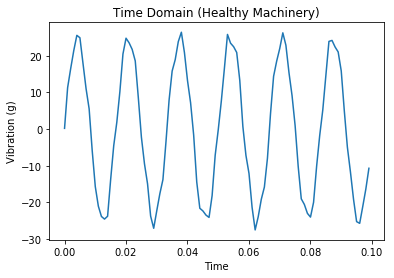

In [1]:
import numpy as np
from scipy import pi
import matplotlib.pyplot as plt
%matplotlib inline

# Sampling rate and time vector
start_time = 0 # seconds
end_time = 2 # seconds
sampling_rate = 1000 # Hz
N = (end_time - start_time)*sampling_rate # array size

# Frequency domain peaks
peak1_hz = 60 # Hz where the peak occurs
peak1_mag = 25 # magnitude of the peak
peak2_hz = 270 # Hz where the peak occurs
peak2_mag = 2 # magnitude of the peak

# Noise control
noise_loc = 0 # the Gaussian noise is mean-centered
noise_mag = 0.5 # magnitude of added noise

# Vibration data generation
time = np.linspace(start_time, end_time, N)
vib_data = peak1_mag*np.sin(2*pi*peak1_hz*time) + \
           peak2_mag*np.sin(2*pi*peak2_hz*time) + \
           np.random.normal(0, noise_mag, N) 

# Data plotting
plt.plot(time[0:100], vib_data[0:100])
plt.xlabel('Time')
plt.ylabel('Vibration (g)')
plt.title('Time Domain (Healthy Machinery)');

Notice that the sinusoidal shape is fairly recognizable; this effect occurs because the 60 Hz peak has a high magnitude compared to the 270 Hz peak, and the amount of added Gaussian noise is minimal. The peak-to-peak measurement in the figure is greater than 0.015 seconds but less than 0.02 seconds; in fact, it's equal to 1/60 Hz, or about 0.017 seconds.

Both numpy and scipy contain functions for evaluating a Discrete Fourier Transform. We will be using the scipy.fftpack.ftt function in this example. This function will use the time-domain vibration data we created above to generate frequency-domain data.

According to the [Nyquist-Shannon Sampling Theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem), beyond the scope of this blog post, we can only examine frequency-spectrum components up to the sampling rate divided by two. Increasing the sampling rate will widen the available frequency spectrum (we can look at higher frequencies); increasing the number of data samples will increase the resolution of the FFT (generally, the frequency spectrum is more accurate). Our sampling rate was 1000 Hz, so we can safely examine frequencies up to 500 Hz, which is greater than the largest frequency of interest (270 Hz).

The following code will generate the frequency spectrum of the vibration data using the scipy.fftpack.ftt function. The fft function will generate both the "positive-frequency" and "negative-frequency" parts of the spectrum (see [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fft.html) for more information), so we 

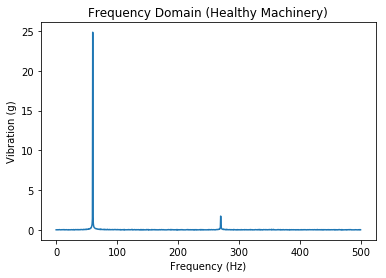

In [2]:
from scipy.fftpack import fft

# Nyquist Sampling Criteria
T = 1/sampling_rate # inverse of the sampling rate
x = np.linspace(0.0, 1.0/(2.0*T), int(N/2))

# FFT algorithm
yr = fft(vib_data) # "raw" FFT with both + and - frequencies
y = 2/N * np.abs(yr[0:np.int(N/2)]) # positive freqs only

# Plotting the results
plt.plot(x, y)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Vibration (g)')
plt.title('Frequency Domain (Healthy Machinery)');

In the figure above, the primary peak can be seen at 60 Hz (rotating frequency of the equipment), while the secondary peak is at 270 Hz, as expected (ball pass frequency). 

What if the bearing had a fault? If so, the magnitude of the peak at 270 Hz would be expected to increase, as in the following figure:

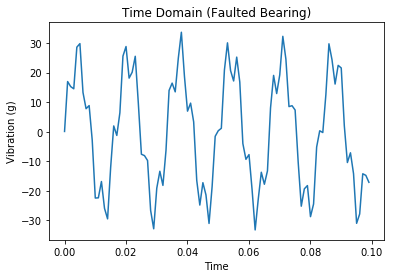

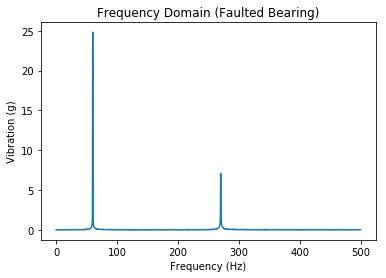

In [3]:
# Time-Domain Plot
peak2_mag2 = 8 # magnitude of the peak
vib_data2 = peak1_mag*np.sin(2*pi*peak1_hz*time) + \
            peak2_mag2*np.sin(2*pi*peak2_hz*time) + \
            np.random.normal(0, noise_mag, N) 
plt.figure()
plt.plot(time[0:100], vib_data2[0:100])
plt.xlabel('Time')
plt.ylabel('Vibration (g)')
plt.title('Time Domain (Faulted Bearing)')

# Frequency-Domain Plot
yr2 = fft(vib_data2) # "raw" FFT with both + and - frequencies
y2 = 2/N * np.abs(yr2[0:np.int(N/2)]) # positive freqs only
plt.figure()
plt.plot(x, y2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Vibration (g)')
plt.title('Frequency Domain (Faulted Bearing)');

Notice that the 60 Hz component in the time-domain signal is slightly less recognizable, and the magnitude of the 270 Hz peak in the frequency-domain has increased significantly. 

For monitoring the bearing condition, the maximum "narrowband" ball pass frequency (e.g. the band of frequencies between 260 Hz and 280 Hz) will be trended over time. If the magnitude of the peak deviates significantly from the magnitude under healthy machinery operation (e.g. increasing beyond the 1% confidence interval of the distribution of the peak magnitudes under normal operation), a bearing failure is likely imminent (diagnostics). If these vibration measurements are fairly noise-free and trendable over time, the failure of the bearing can be predicted in advance (prognostics) by determining the amount of time until the bearing reaches a predefined fault threshold.

Finally, what would happen if our sampling rate had been lower than the Nyquist Sampling Theorem? Let's reduce the sampling rate to 500 Hz and find out:

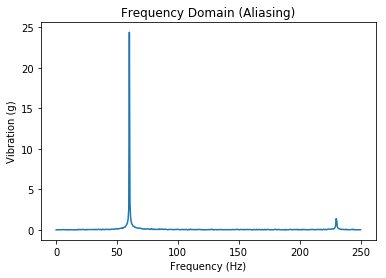

In [4]:
# Reduced sampling frequency
sampling_rate3 = 500 # Hz
N3 = (end_time - start_time)*sampling_rate3 # array size
time3 = np.linspace(start_time, end_time, N3)
vib_data3 = peak1_mag*np.sin(2*pi*peak1_hz*time3) + \
           peak2_mag*np.sin(2*pi*peak2_hz*time3) + \
           np.random.normal(0, noise_mag, N3) 
T3 = 1/sampling_rate3 # inverse of the sampling rate
x3 = np.linspace(0.0, 1.0/(2.0*T3), int(N3/2))

# FFT algorithm
yr3 = fft(vib_data3) # "raw" FFT with both + and - frequencies
y3 = 2/N3 * np.abs(yr3[0:np.int(N3/2)]) # positive freqs only

# Plotting the results
plt.plot(x3, y3)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Vibration (g)')
plt.title('Frequency Domain (Aliasing)');

Notice that the bearing ball pass frequency was shifted from 270 Hz to 230 Hz. This effect is known as an [aliasing artifact](https://en.wikipedia.org/wiki/Aliasing). If we didn't know that there was a 270 Hz component in the time-domain signal, and our sampling rate was too low, we might have been fooled by the appearance of a 230 Hz peak and been unable to explain where it came from.

In today's world, disk space is cheap. Don't be afraid to sample the data at a higher rate than you expect to need. It reduces the possibility of aliasing due to factors that you didn't expect. Furthermore, it's always easy to reduce the size of your data in the future, if you ever need to do so.